In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.pdfigcapx.utils import extract_page_text_content, sort_by_most_common_value_desc
from selenium import webdriver
from pathlib import Path

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image

from src.pdfigcapx.html_content import HtmlPage, PageBoxesCounts
from src.pdfigcapx.layout import PdfLayout

In [2]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--headless')
driver = webdriver.Chrome('chromedriver', options=chrome_options)

## Sample Data
We have preprocessed a PDF document (**/tests/data/pdf-1.pdf**) and obtained 
and HTML and PNG representation for each PDF page. The PNG representation shows
the page background that can include images but no text. The HTML page contains
all text information inside DIVs.

In [3]:
number_pages = 20
file_path = '../tests/data/htmls/page'

htmls = []
pngs  = []
for i in range(1, number_pages+1):
  htmls.append(str(Path(f"{file_path}{i}.html").resolve()))
  pngs.append(str(Path(f"{file_path}{i}.png").resolve()))

pages = []
for html in htmls:
  pages.append(extract_page_text_content(driver, html))

## Find Local Counts?

In [4]:
MIN_TEXT_LENGTH = 30
layout = PdfLayout([pages[0]], min_text_length=MIN_TEXT_LENGTH)

In [23]:
def draw_page_elements(ax, page: HtmlPage, png_path: str, min_text_length=30):
  page_image = Image.open(png_path)
  page_image = page_image.resize((page.width, page.height), Image.ANTIALIAS)
  # _, ax = plt.subplots(dpi=150)

  layout = PdfLayout([page], min_text_length=min_text_length)
  (left_bbox, right_bbox, top_bbox, bottom_bbox) = layout.find_surrounding_bboxes()

  # contrains in Y axis for finding text
  text_area = patches.Rectangle((0, layout.text_y_min),
                              layout.page_width,
                              layout.text_y_max-layout.text_y_min,
                              linewidth=0,
                              edgecolor='none',
                              facecolor='y',
                              alpha=0.2)
  ax.add_patch(text_area)

  # DIVs with text on page, red ones are smaller than minimum length
  for text_box in page.text_boxes:
    color = 'b' if len(text_box.text) > min_text_length else 'r'
    rect = patches.Rectangle((text_box.x_top_left, text_box.y_top_left),
                              text_box.width, text_box.height,
                              linewidth=0,
                              edgecolor='none',
                              facecolor=color,
                              alpha=0.4)
    ax.add_patch(rect)

  # minimum x for the most common x0 in text boxes
  ax.plot([layout.text_x_common_min, layout.text_x_common_min],
          [0, page.height],
          color="g", linestyle='--')

  # minimum x0
  ax.plot([layout.text_x_min, layout.text_x_min],
          [0, page.height],
          color="g", linestyle='--')

  for bbox in (left_bbox, right_bbox, top_bbox, bottom_bbox):
    rect = patches.Rectangle((bbox.x0, bbox.y0),
                              bbox.width, bbox.height,
                              linewidth=0,
                              edgecolor='none',
                              facecolor='gray',
                              alpha=0.5)
    ax.add_patch(rect)          

  ax.imshow(page_image)

In [27]:
cols = 3
rows = number_pages // cols
cols, rows

(3, 6)

In [43]:
3 % rows

3

6

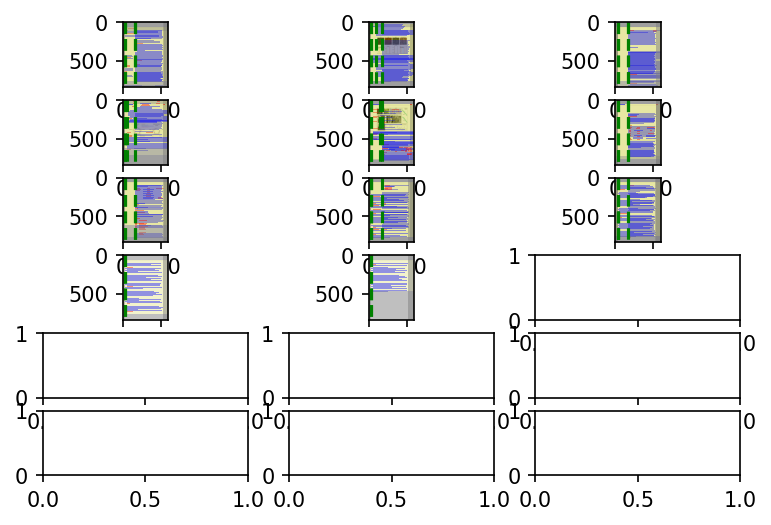

In [44]:
cols = 3
rows = len(pages) // cols

fig, ax = plt.subplots(rows,cols,dpi=150)
for idx, page in enumerate(pages):
   idx_row = idx // rows
   draw_page_elements(ax[idx_row, idx_col], pages[idx], pngs[idx], min_text_length=MIN_TEXT_LENGTH)
len(ax)

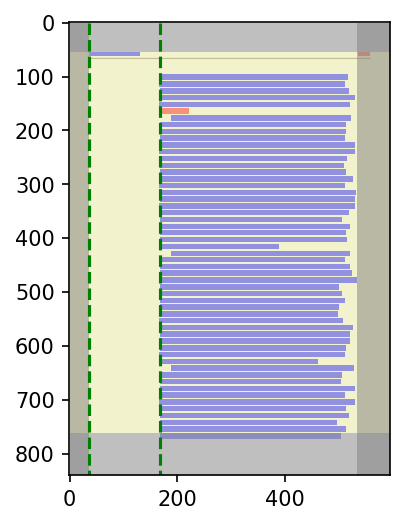

In [20]:
draw_page_elements(pages[1], pngs[1], min_text_length=MIN_TEXT_LENGTH)

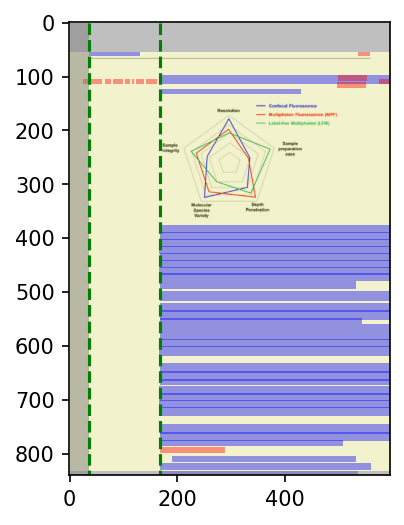

In [21]:
draw_page_elements(pages[2], pngs[2], min_text_length=MIN_TEXT_LENGTH)

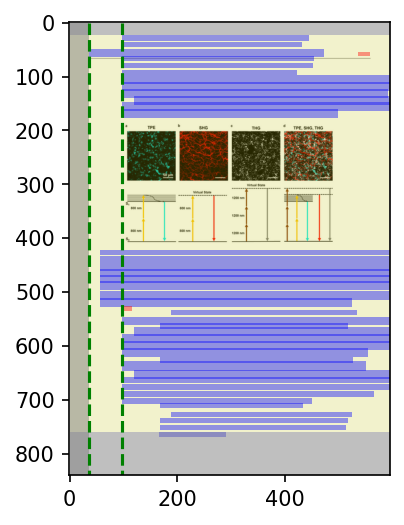

In [22]:
draw_page_elements(pages[4], pngs[4], min_text_length=MIN_TEXT_LENGTH)